<a href="https://colab.research.google.com/github/stanfish06/google-colab/blob/main/scvi_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install --quiet scvi-colab
from scvi_colab import install
install()

Mounted at /content/drive
INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.12/dist-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [2]:
import os
import tempfile

import ray
import scanpy as sc
import scvi
import seaborn as sns
import torch
import pandas as pd
import numpy as np
from ray import tune
from scvi import autotune

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"

/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/usr/local/lib/python3.12/dist-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = "/content/drive/MyDrive/micropattern_42487296_tune"
scvi.settings.logging_dir = save_dir

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.4.0


In [4]:
# load in and process data
data_dir = "/content/drive/MyDrive/MASV/Zhiyuan's Team - 202403141948/"
data_list = ['adata_timeseries_all_v2.h5ad', 'adata_2020_force_9000.h5ad', 'adata_2021_BMP_contorl.h5ad']
labels = [None, "42h", "42h"]
adata = []
print("start:", end="\n", flush=True)
for l, f in zip(labels, data_list):
  adata_tmp = sc.read_h5ad(data_dir + f)
  if l is not None:
    adata_tmp.obs["time_point"] = l
  else:
    adata_tmp.obs["time_point"] = [s.split("-")[0] for s in adata_tmp.obs["sample_labels"]]
  adata.append(adata_tmp)
# do outer join here due to same system
print(".", end="", flush=True)
adata = sc.concat(adata, join='outer', fill_value=0)
adata.layers['counts'] = adata.X.copy()
# store raw count
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
print(".", end="\n", flush=True)
# globally normalized log1p
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    batch_key="sample_labels",
    flavor="seurat_v3",
    n_top_genes=1000,
    subset=True
)
print("done", end="\n", flush=True)

start:
..
done


In [5]:
cc_genes_file = "/content/drive/MyDrive/MASV/Zhiyuan's Team - 202402291934/Macosko_cell_cycle_genes.txt"
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()
m_genes = cc_genes['M'].dropna()
mg1_genes = cc_genes['M.G1'].dropna()
nuisance_genes = [g for g in adata.var_names if g.split()[0] in set(list(s_genes)+list(m_genes)+list(g2m_genes))]
sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=[g for g in adata.var_names if g.split()[0] in list(s_genes)],
    g2m_genes=[g for g in adata.var_names if g.split()[0] in list(g2m_genes)]
)
for g in nuisance_genes:
  if g not in adata.obs.columns:
    adata.obs[g] = adata[:, g].X.toarray()
adata_cc = adata[:, ~np.isin(adata.var_names, nuisance_genes)].copy()
print(len(nuisance_genes))
print(adata)
print(adata_cc)
print(adata_cc.obs.columns)

32
AnnData object with n_obs × n_vars = 57323 × 1000
    obs: 'sample_labels', 'time_point', 'S_score', 'G2M_score', 'phase', 'ARL6IP1 (ENSG00000170540)', 'AURKA (ENSG00000087586)', 'CALD1 (ENSG00000122786)', 'CALM2 (ENSG00000143933)', 'CDC42EP1 (ENSG00000128283)', 'CDCA3 (ENSG00000111665)', 'CDK1 (ENSG00000170312)', 'CENPA (ENSG00000115163)', 'CENPE (ENSG00000138778)', 'CENPF (ENSG00000117724)', 'CKS2 (ENSG00000123975)', 'DEPDC1 (ENSG00000024526)', 'DLGAP5 (ENSG00000126787)', 'GAS1 (ENSG00000180447)', 'GCLM (ENSG00000023909)', 'H1F0 (ENSG00000189060)', 'HIST1H4C (ENSG00000197061)', 'HMMR (ENSG00000072571)', 'KIF23 (ENSG00000137807)', 'KPNA2 (ENSG00000182481)', 'MALAT1 (ENSG00000251562)', 'MKI67 (ENSG00000148773)', 'NEAT1 (ENSG00000245532)', 'NUSAP1 (ENSG00000137804)', 'PIF1 (ENSG00000140451)', 'PLK1 (ENSG00000166851)', 'RHOBTB3 (ENSG00000164292)', 'SEPHS1 (ENSG00000086475)', 'TFAP2A (ENSG00000137203)', 'TOP2A (ENSG00000131747)', 'TPX2 (ENSG00000088325)', 'UBE2C (ENSG00000175063)'
    

In [8]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(
    adata_cc,
    layer="counts",
    batch_key="sample_labels",
    labels_key="time_point",
    continuous_covariate_keys=nuisance_genes
)

In [9]:
search_space = {
    "model_params": {
        "n_hidden": tune.choice([64, 128, 256]),
        "n_layers": tune.choice([1, 2, 3]),
        "n_latent": tune.choice([20, 30, 40]),
        "deeply_inject_covariates": tune.choice([True, False]),
        'gene_likelihood': tune.choice(['nb', 'zinb']),
        "use_batch_norm": tune.choice(['none', 'both'])
    },
    "train_params": {
        "max_epochs": 40,
        "plan_kwargs": {"lr": tune.choice([1e-3, 1e-2])}
    },
}

In [10]:
# ray.shutdown()

In [ ]:
ray.init(log_to_driver=False)
results = autotune.run_autotune(
    model_cls,
    data=adata_cc,
    metrics="Total",
    mode="max",
    search_space=search_space,
    num_samples=60,
    seed=0,
    scheduler="asha",
    searcher="hyperopt",
    resources={"cpu": 12, "gpu": 1},
    scib_subsample_rows=10000,
    local_mode=True,
    ignore_reinit_error=True,
    solver="randomized"
)

2025-09-17 03:52:27,790	INFO worker.py:1951 -- Started a local Ray instance.


INFO     Running autotune experiment scvi_36879fc8-c8a5-4699-a45c-3634473eb8f6.                                    


2025-09-17 03:52:31,912	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.


+------------------------------------------------------------------------------+
| Configuration for experiment     scvi_36879fc8-c8a5-4699-a45c-3634473eb8f6   |
+------------------------------------------------------------------------------+
| Search algorithm                 SearchGenerator                             |
| Scheduler                        AsyncHyperBandScheduler                     |
| Number of trials                 60                                          |
+------------------------------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/micropattern_42487296_tune/scvi_36879fc8-c8a5-4699-a45c-3634473eb8f6/scvi_36879fc8-c8a5-4699-a45c-3634473eb8f6
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-09-17_03-52-24_764412_14976/artifacts/2025-09-17_03-52-32/scvi_36879fc8-c8a5-4699-a45c-3634473eb8f6/driver_artifacts`

Trial status: 1 PENDING
Current time: 2025-09-17 03:52:33.

In [10]:
scvi.model.SCVI.setup_anndata(
    adata_cc,
    layer="counts",
    batch_key="sample_labels",
    continuous_covariate_keys=nuisance_genes
)
model = scvi.model.SCVI(
    adata_cc,
    n_latent=30,
    n_hidden=128,
    n_layers=2,
    gene_likelihood='nb',
    deeply_inject_covariates=False,
    use_batch_norm='both'
)
model.train(
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=50,
    check_val_every_n_epoch=1,
    plan_kwargs={"lr": 1e-3}
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider incr

Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [12]:
qzm, qzv = model.get_latent_representation(give_mean=False, return_dist=True)
model.adata.obsm["X_scvi_qzm"] = qzm
model.adata.obsm["X_scvi_qzv"] = qzv
model.minify_adata(use_latent_qzm_key="X_scvi_qzm", use_latent_qzv_key="X_scvi_qzv")
model.save("250917_SCVI_micropattern_D2-4", save_anndata=True, overwrite=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


<Axes: xlabel='epoch'>

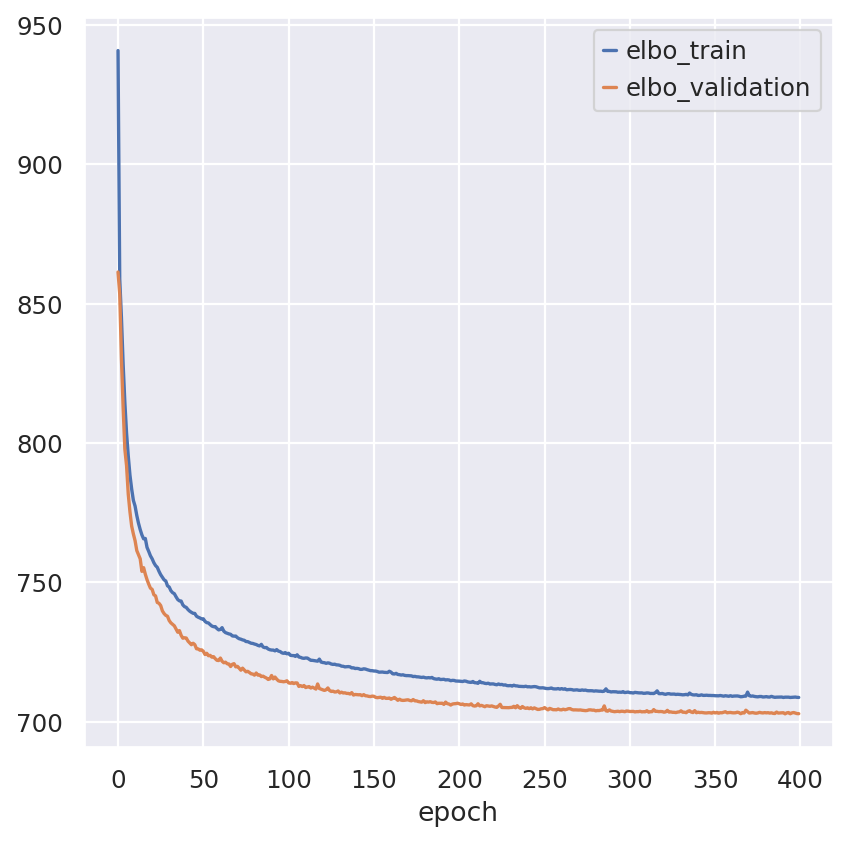

In [38]:
pd.concat([model.history_['elbo_train'], model.history_['elbo_validation']], axis=1).plot()

In [71]:
from scvi.hub import HubMetadata, HubModel, HubModelCardHelper
import anndata
model_path = "250917_SCVI_micropattern_D2-4"
hm = HubMetadata.from_dir(model_path, anndata_version=anndata.__version__)
hmch = HubModelCardHelper.from_dir(
    model_path,
    license_info="cc-by-4.0",
    anndata_version=anndata.__version__,
    data_modalities=["rna"],
    data_is_annotated=False,
    description="scRNAseq data for D2-D4 human gastruloids",
    references="None.",
)

INFO     File 250917_SCVI_micropattern_D2-4/model.pt already downloaded                                            
INFO     File 250917_SCVI_micropattern_D2-4/model.pt already downloaded                                            


In [40]:
hmch.model_card.save("model_card.md")

In [82]:
hmo = HubModel(model_path, metadata=hm, model_card=hmch)

In [73]:
# needed so that push_to_huggingface_hub does not use scvi's official collection
hmo.metadata.model_cls_name = "none"
hug_token=""

In [74]:
hmo.push_to_huggingface_hub(
    repo_name="stanfish06/scRNAseq-human-gastruloid", repo_token=hug_token, repo_create=True, push_anndata=True
)

/usr/local/lib/python3.12/dist-packages/scvi/utils/_dependencies.py:24: UserWarning: No collection found for this model.Please request a new collection for none.
  return fn(*args, **kwargs)


In [81]:
from huggingface_hub import upload_file
with open(model_path + '/adata.h5ad', "rb") as fobj:
  upload_file(
      path_or_fileobj=fobj,
      path_in_repo="adata.h5ad",
      repo_id="stanfish06/scRNAseq-human-gastruloid",
      token=hug_token,
  )
with open(model_path + '/model.pt', "rb") as fobj:
  upload_file(
      path_or_fileobj=fobj,
      path_in_repo="model.pt",
      repo_id="stanfish06/scRNAseq-human-gastruloid",
      token=hug_token,
  )

Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
